In [1]:
import pandas as pd
import xarray as xr
from pathlib import Path
import datetime
from cftime import num2date
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the folder path containing the NetCDF files
folder_path = Path('inputs\WindData')
datasets = []  # List to store datasets

for file in folder_path.iterdir():
    ds = xr.open_dataset(file)  # Open each NetCDF file
    datasets.append(ds)  # Store dataset in list

# Concatenate along a specific dimension (e.g., 'time' if it exists)
combined_ds = xr.concat(datasets, dim='valid_time')

# Convert the combined dataset to a pandas DataFrame
WindData = combined_ds.to_dataframe().reset_index()


In [3]:
# Display the combined dataset
WindData

,valid_time,latitude,longitude,number,expver,u10,v10,u100,v100
0,1997-01-01 00:00:00,8.00,55.50,0,0001,-5.129883,-7.070343,-5.775009,-7.893539
1,1997-01-01 00:00:00,8.00,55.75,0,0001,-5.128906,-7.074249,-5.767197,-7.916000
2,1997-01-01 00:00:00,7.75,55.50,0,0001,-5.064453,-7.151398,-5.692978,-7.980453
3,1997-01-01 00:00:00,7.75,55.75,0,0001,-5.052734,-7.126007,-5.681259,-7.950180
4,1997-01-01 01:00:00,8.00,55.50,0,0001,-5.460739,-7.175369,-6.158142,-8.034683
...,...,...,...,...,...,...,...,...,...
946651,2023-12-31 22:00:00,7.75,55.75,0,0001,-4.193115,-4.812347,-4.692459,-5.313354
946652,2023-12-31 23:00:00,8.00,55.50,0,0001,-3.792526,-5.225235,-4.245819,-5.772034
946653,2023-12-31 23:00:00,8.00,55.75,0,0001,-3.910690,-5.023087,-4.380585,-5.562073
946654,2023-12-31 23:00:00,7.75,55.50,0,0001,-3.795456,-5.147110,-4.232147,-5.684143


In [4]:
# Separate the wind speeds in the four different points, using the latitude and longitude information

WindData = WindData.rename(columns={'number': 'location'}) # Change the meaning of the existing column 'number' which was not being used

WindData['location'] = list(zip(WindData['latitude'], WindData['longitude'])) # Combines latitude and longitude on the column location



In [5]:
WindData

,valid_time,latitude,longitude,location,expver,u10,v10,u100,v100
0,1997-01-01 00:00:00,8.00,55.50,"(8.0, 55.5)",0001,-5.129883,-7.070343,-5.775009,-7.893539
1,1997-01-01 00:00:00,8.00,55.75,"(8.0, 55.75)",0001,-5.128906,-7.074249,-5.767197,-7.916000
2,1997-01-01 00:00:00,7.75,55.50,"(7.75, 55.5)",0001,-5.064453,-7.151398,-5.692978,-7.980453
3,1997-01-01 00:00:00,7.75,55.75,"(7.75, 55.75)",0001,-5.052734,-7.126007,-5.681259,-7.950180
4,1997-01-01 01:00:00,8.00,55.50,"(8.0, 55.5)",0001,-5.460739,-7.175369,-6.158142,-8.034683
...,...,...,...,...,...,...,...,...,...
946651,2023-12-31 22:00:00,7.75,55.75,"(7.75, 55.75)",0001,-4.193115,-4.812347,-4.692459,-5.313354
946652,2023-12-31 23:00:00,8.00,55.50,"(8.0, 55.5)",0001,-3.792526,-5.225235,-4.245819,-5.772034
946653,2023-12-31 23:00:00,8.00,55.75,"(8.0, 55.75)",0001,-3.910690,-5.023087,-4.380585,-5.562073
946654,2023-12-31 23:00:00,7.75,55.50,"(7.75, 55.5)",0001,-3.795456,-5.147110,-4.232147,-5.684143


In [6]:
# Convert from cartessian cordinates of velocity to polar coordinates to obtain wind direction and speed, for every location

WindData['ws_10'] = (WindData['u10']**2 + WindData['v10']**2)**0.5
WindData['wd_10'] = (np.arctan2(WindData['u10'], WindData['v10']) * 360 / (2 * np.pi)) % 360  # Wind direction in degrees (0, 360)



WindData['ws_100'] = (WindData['u100']**2 + WindData['v100']**2)**0.5
WindData['wd_100'] = (np.arctan2(WindData['u100'], WindData['v100']) * 360 / (2 * np.pi)) % 360  # Wind direction in degrees

#separate the wind speeds in the four locations
Location_1 = WindData[WindData['location'] == (7.75, 55.5)]
Location_2 = WindData[WindData['location'] == (8, 55.5)]
Location_3 = WindData[WindData['location'] == (7.75, 55.75)]
Location_4 = WindData[WindData['location'] == (8, 55.75)]

Location_1


,valid_time,latitude,longitude,location,expver,u10,v10,u100,v100,ws_10,wd_10,ws_100,wd_100
2,1997-01-01 00:00:00,7.75,55.5,"(7.75, 55.5)",0001,-5.064453,-7.151398,-5.692978,-7.980453,8.763058,215.305252,9.802940,215.502747
6,1997-01-01 01:00:00,7.75,55.5,"(7.75, 55.5)",0001,-5.412888,-7.168533,-6.093689,-8.018082,8.982607,217.056091,10.070883,217.234604
10,1997-01-01 02:00:00,7.75,55.5,"(7.75, 55.5)",0001,-5.794968,-7.286667,-6.540344,-8.170639,9.310057,218.494659,10.465919,218.676193
14,1997-01-01 03:00:00,7.75,55.5,"(7.75, 55.5)",0001,-6.116409,-7.345795,-6.927292,-8.274216,9.558826,219.782150,10.791201,219.936554
18,1997-01-01 04:00:00,7.75,55.5,"(7.75, 55.5)",0001,-6.399673,-7.414078,-7.274658,-8.381561,9.794099,220.800064,11.098253,220.955887
...,...,...,...,...,...,...,...,...,...,...,...,...,...
946638,2023-12-31 19:00:00,7.75,55.5,"(7.75, 55.5)",0001,-5.853882,-5.125351,-6.685028,-5.842255,7.780563,228.796310,8.878150,228.848770
946642,2023-12-31 20:00:00,7.75,55.5,"(7.75, 55.5)",0001,-5.822296,-4.957687,-6.579819,-5.582153,7.647078,229.585602,8.628699,229.689575
946646,2023-12-31 21:00:00,7.75,55.5,"(7.75, 55.5)",0001,-5.104568,-4.827011,-5.758743,-5.412628,7.025429,226.600830,7.903143,226.774597
946650,2023-12-31 22:00:00,7.75,55.5,"(7.75, 55.5)",0001,-4.149170,-5.090668,-4.661209,-5.626831,6.567382,219.181900,7.306716,219.638000


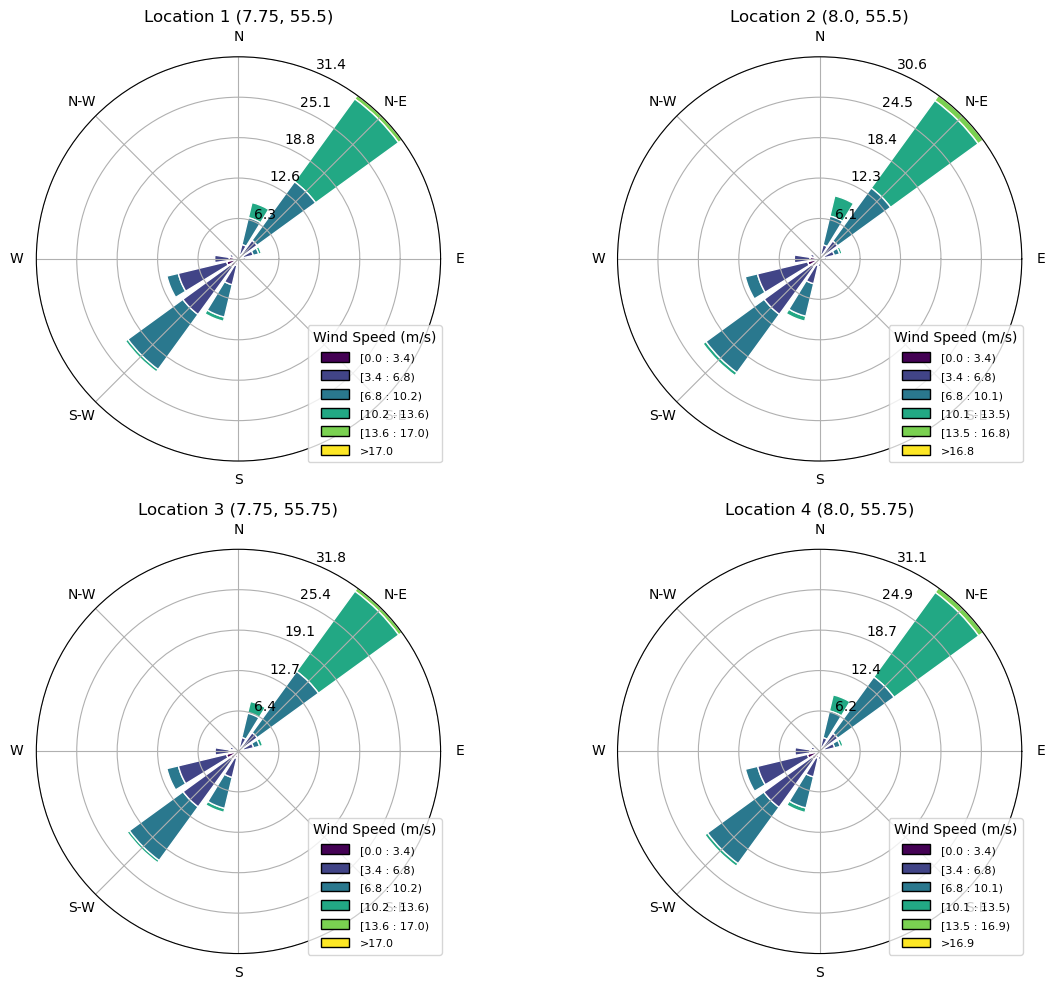

In [7]:
from windrose import WindroseAxes

# Create a 2x2 subplot for wind rose plots
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'windrose'}, figsize=(12, 10))

# Plot for Location_1
axes[0, 0].bar(Location_1['wd_10'], Location_1['ws_10'], normed=True, opening=0.8, edgecolor='white')
axes[0, 0].set_title("Location 1 (7.75, 55.5)")
axes[0, 0].set_legend(title="Wind Speed (m/s)", loc='lower right')

# Plot for Location_2
axes[0, 1].bar(Location_2['wd_10'], Location_2['ws_10'], normed=True, opening=0.8, edgecolor='white')
axes[0, 1].set_title("Location 2 (8.0, 55.5)")
axes[0, 1].set_legend(title="Wind Speed (m/s)", loc='lower right')

# Plot for Location_3
axes[1, 0].bar(Location_3['wd_10'], Location_3['ws_10'], normed=True, opening=0.8, edgecolor='white')
axes[1, 0].set_title("Location 3 (7.75, 55.75)")
axes[1, 0].set_legend(title="Wind Speed (m/s)", loc='lower right')

# Plot for Location_4
axes[1, 1].bar(Location_4['wd_10'], Location_4['ws_10'], normed=True, opening=0.8, edgecolor='white')
axes[1, 1].set_title("Location 4 (8.0, 55.75)")
axes[1, 1].set_legend(title="Wind Speed (m/s)", loc='lower right')

plt.tight_layout()
plt.show()

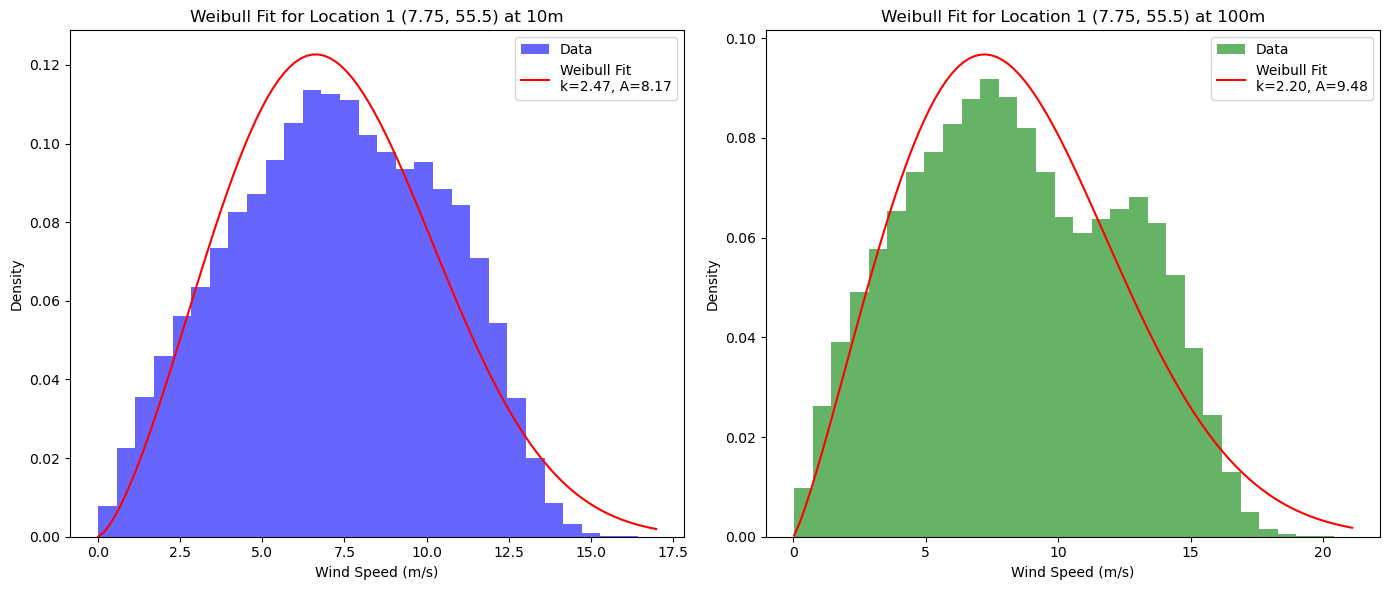

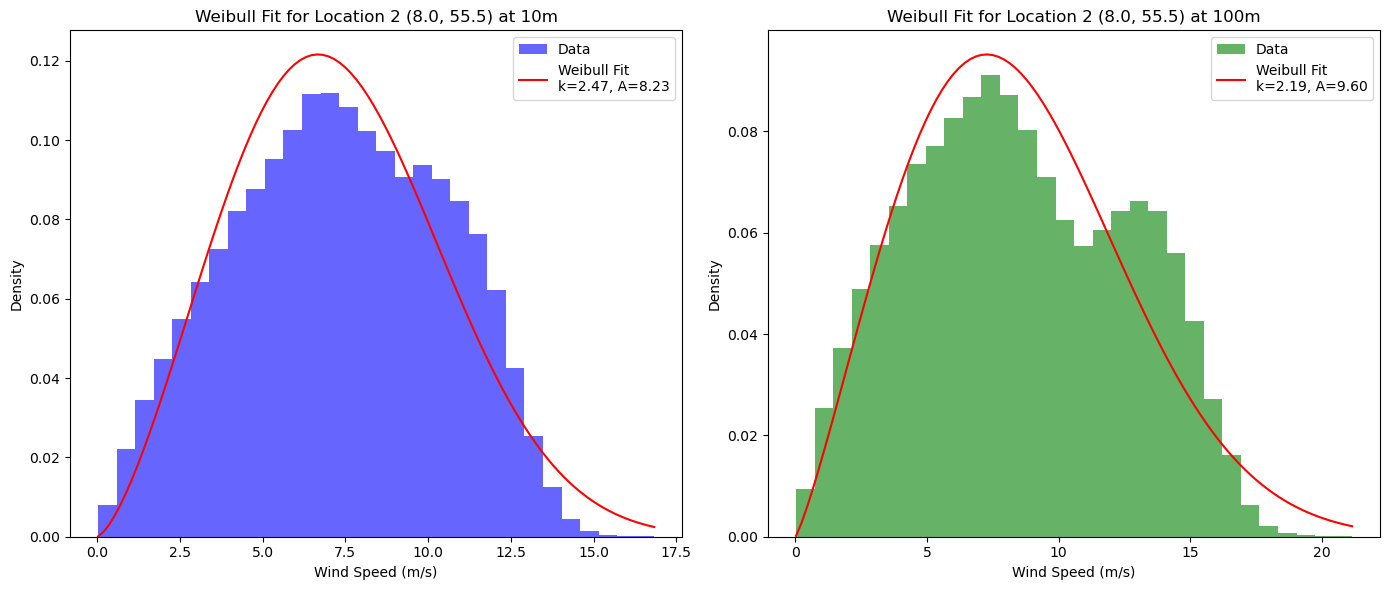

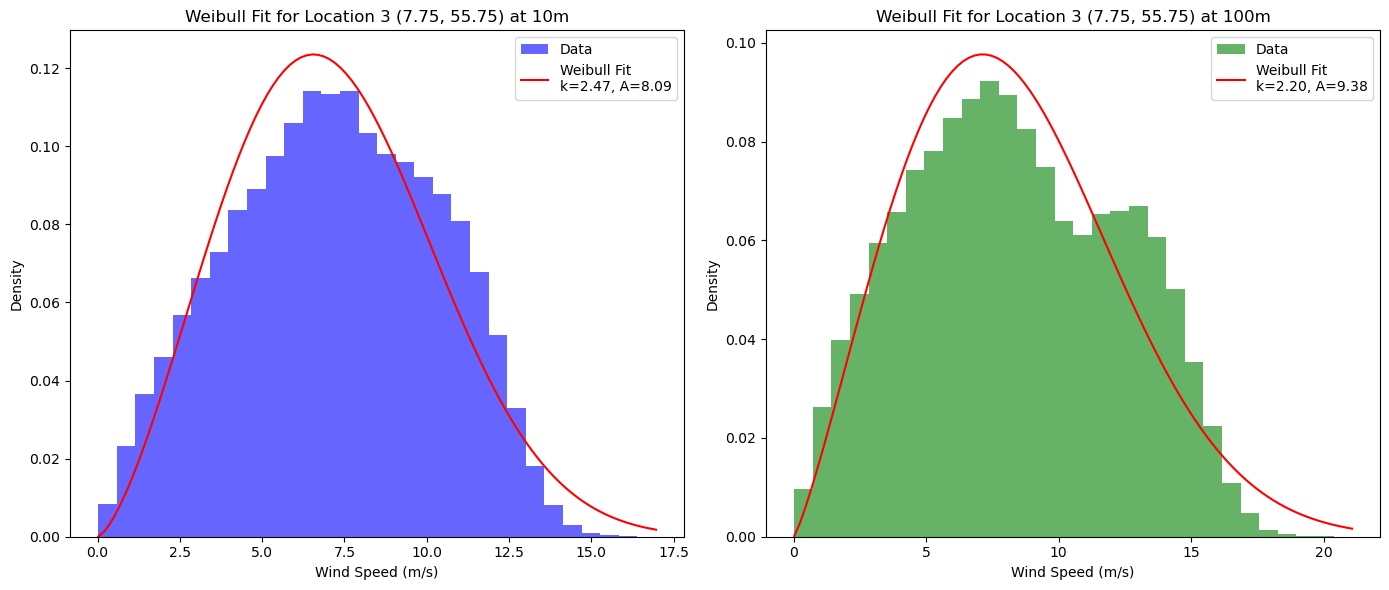

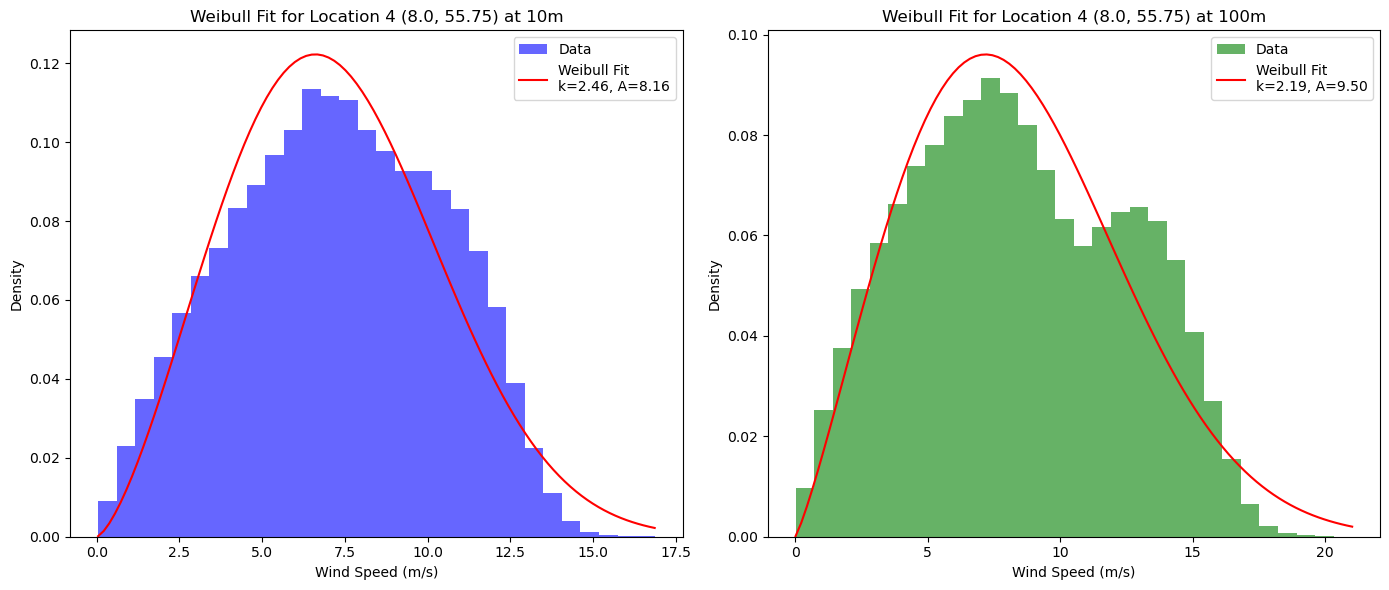

In [11]:
from scipy.stats import weibull_min

import matplotlib.pyplot as plt

# Function to fit Weibull distribution and plot
def fit_weibull(location_data, location_name):
    # Extract wind speed data at 10m and 100m heights
    wind_speeds_10 = location_data['ws_10']
    wind_speeds_100 = location_data['ws_100']
    
    # Fit Weibull distribution for 10m
    shape_10, loc_10, scale_10 = weibull_min.fit(wind_speeds_10, floc=0)  # Fix location to 0
    
    # Fit Weibull distribution for 100m
    shape_100, loc_100, scale_100 = weibull_min.fit(wind_speeds_100, floc=0)  # Fix location to 0
    
    # Generate data for plotting
    x_10 = np.linspace(wind_speeds_10.min(), wind_speeds_10.max(), 100)
    pdf_10 = weibull_min.pdf(x_10, shape_10, loc_10, scale_10)
    
    x_100 = np.linspace(wind_speeds_100.min(), wind_speeds_100.max(), 100)
    pdf_100 = weibull_min.pdf(x_100, shape_100, loc_100, scale_100)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot for 10m
    axes[0].hist(wind_speeds_10, bins=30, density=True, alpha=0.6, color='blue', label='Data')
    axes[0].plot(x_10, pdf_10, 'r-', label=f'Weibull Fit\nk={shape_10:.2f}, A={scale_10:.2f}')
    axes[0].set_title(f'Weibull Fit for {location_name} at 10m')
    axes[0].set_xlabel('Wind Speed (m/s)')
    axes[0].set_ylabel('Density')
    axes[0].legend()
    
    # Plot for 100m
    axes[1].hist(wind_speeds_100, bins=30, density=True, alpha=0.6, color='green', label='Data')
    axes[1].plot(x_100, pdf_100, 'r-', label=f'Weibull Fit\nk={shape_100:.2f}, A={scale_100:.2f}')
    axes[1].set_title(f'Weibull Fit for {location_name} at 100m')
    axes[1].set_xlabel('Wind Speed (m/s)')
    axes[1].set_ylabel('Density')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Fit and plot Weibull distribution for each location
fit_weibull(Location_1, "Location 1 (7.75, 55.5)")
fit_weibull(Location_2, "Location 2 (8.0, 55.5)")
fit_weibull(Location_3, "Location 3 (7.75, 55.75)")
fit_weibull(Location_4, "Location 4 (8.0, 55.75)")

In [9]:
from scipy.interpolate import RegularGridInterpolator
import numpy as np

# Coordinates and data organization
points = np.array([[7.75, 55.5], [8, 55.5], [7.75, 55.75], [8, 55.75]])
x_coords = np.unique(points[:, 0])  # [7.75, 8.0]
y_coords = np.unique(points[:, 1])  # [55.5, 55.75]

# Prepare wind data (assuming all Locations have same length)

'''Extract wind speed and direction data for each location at 10 m height'''
ws_data10 = np.array([loc['ws_10'].values for loc in [Location_1, Location_2, Location_3, Location_4]])
wd_data10 = np.array([loc['wd_10'].values for loc in [Location_1, Location_2, Location_3, Location_4]])

'''Extract wind speed and direction data for each location at 100 m height'''
ws_data100 = np.array([loc['ws_100'].values for loc in [Location_1, Location_2, Location_3, Location_4]])
wd_data100 = np.array([loc['wd_100'].values for loc in [Location_1, Location_2, Location_3, Location_4]])

# Reshape to grid format (2x2xtime)
wd_grid10 = wd_data10.reshape(2, 2, -1)
wd_grid100 = wd_data100.reshape(2, 2, -1)

# Wind direction conversion into radians
'''Wind direction is circular (0°=360°). Converting to vectors avoids interpolation errors'''
def degree_to_vector(degrees):
    rad = np.deg2rad(degrees)
    return np.stack([np.cos(rad), np.sin(rad)], axis=-1)

# Call the function to convert wind directions to vectors
wd_vectors10 = degree_to_vector(wd_data10).reshape(2, 2, -1, 2)
wd_vectors100 = degree_to_vector(wd_data100).reshape(2, 2, -1, 2)

# Create interpolators
ws_interpolator10 = RegularGridInterpolator((x_coords, y_coords), wd_grid10, method='linear')
ws_interpolator100 = RegularGridInterpolator((x_coords, y_coords), wd_grid100, method='linear')


wd_interpolator10 = RegularGridInterpolator((x_coords, y_coords), wd_vectors10, method='linear')
wd_interpolator100 = RegularGridInterpolator((x_coords, y_coords), wd_vectors100, method='linear')

# Interpolate
target = (7.90, 55.60)

interp_speed10 = ws_interpolator10(target)
interp_speed100 = ws_interpolator100(target)

interp_vector10 = wd_interpolator10(target)
interp_vector100 = wd_interpolator100(target)

# Convert vector back to degrees
interp_wd10 = np.rad2deg(np.arctan2(interp_vector10[..., 1], interp_vector10[..., 0])) % 360
interp_wd100 = np.rad2deg(np.arctan2(interp_vector100[..., 1], interp_vector100[..., 0])) % 360

print(f"Interpolated wind speeds at 10 m: {interp_speed10}")
print(f"Interpolated wind directions at 10 m: {interp_wd10}")
print("---------------------------------------------------------------------")
print(f"Interpolated wind speeds at 100 m: {interp_speed100}")
print(f"Interpolated wind directions at 100 m: {interp_wd10}")

Interpolated wind speeds at 10 m: [215.57545959 217.51587646 218.68275269 ... 227.52755127 220.35898193
 217.86657654]
Interpolated wind directions at 10 m: [215.57545889 217.51587136 218.68275122 ... 227.52757991 220.35899386
 217.86655894]
---------------------------------------------------------------------
Interpolated wind speeds at 100 m: [215.76701538 217.65792603 218.8265741  ... 227.67530334 220.76845581
 218.10680176]
Interpolated wind directions at 100 m: [215.57545889 217.51587136 218.68275122 ... 227.52757991 220.35899386
 217.86655894]


In [ ]:
# Define the reference heights and target height
z_ref_10 = 10  # Reference height for ws_10
z_ref_100 = 100  # Reference height for ws_100
z_target = 70  # Target height
alpha = 1 / 7  # Wind shear exponent

# Compute wind speed at 70 m for each location using the power law profile
Location_1['ws_70'] = Location_1['ws_10'] * (z_target / z_ref_10)**alpha
Location_2['ws_70'] = Location_2['ws_10'] * (z_target / z_ref_10)**alpha
Location_3['ws_70'] = Location_3['ws_10'] * (z_target / z_ref_10)**alpha
Location_4['ws_70'] = Location_4['ws_10'] * (z_target / z_ref_10)**alpha

# Heights for the plot
heights = [z_ref_10, z_target, z_ref_100]

# Plot wind speed vs height for each location
plt.figure(figsize=(10, 6))

for location, label in zip([Location_1, Location_2, Location_3, Location_4], 
                           ["Location 1 (7.75, 55.5)", "Location 2 (8.0, 55.5)", 
                            "Location 3 (7.75, 55.75)", "Location 4 (8.0, 55.75)"]):
    # Extract wind speeds at 10m, 70m, and 100m
    ws_values = [location['ws_10'].mean(), location['ws_70'].mean(), location['ws_100'].mean()]
    plt.plot(ws_values, heights, marker='o', label=label)

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Height (m)")
plt.title("Wind Speed vs Height")
plt.legend()
plt.grid(True)
plt.show()

            valid_time     ws_10      ws_70
2  1997-01-01 00:00:00  8.763058  11.571348
6  1997-01-01 01:00:00  8.982607  11.861257
10 1997-01-01 02:00:00  9.310057  12.293644
14 1997-01-01 03:00:00  9.558826  12.622136
18 1997-01-01 04:00:00  9.794099  12.932806
            valid_time     ws_10      ws_70
0  1997-01-01 00:00:00  8.735299  11.534694
4  1997-01-01 01:00:00  9.016961  11.906620
8  1997-01-01 02:00:00  9.420454  12.439420
12 1997-01-01 03:00:00  9.669740  12.768594
16 1997-01-01 04:00:00  9.776988  12.910213
            valid_time     ws_10      ws_70
3  1997-01-01 00:00:00  8.735565  11.535046
7  1997-01-01 01:00:00  9.035615  11.931252
11 1997-01-01 02:00:00  9.303769  12.285341
15 1997-01-01 03:00:00  9.552078  12.613226
19 1997-01-01 04:00:00  9.802161  12.943453
            valid_time     ws_10      ws_70
1  1997-01-01 00:00:00  8.737887  11.538112
5  1997-01-01 01:00:00  9.063485  11.968054
9  1997-01-01 02:00:00  9.384309  12.391691
13 1997-01-01 03:00:00  9.556602

C:\Users\srodr\AppData\Local\Temp\ipykernel_19060\2267048427.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Location_1['ws_70'] = Location_1['ws_10'] * (z_target / z_ref_10)**alpha
C:\Users\srodr\AppData\Local\Temp\ipykernel_19060\2267048427.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Location_2['ws_70'] = Location_2['ws_10'] * (z_target / z_ref_10)**alpha
C:\Users\srodr\AppData\Local\Temp\ipykernel_19060\2267048427.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic